# Geospatial case study with machine learning

This notebook contains a case study on a simulated geospatial data for cost for rides in a ride hailing company like Uber,Bolt, or Yandex. The data is for the city of Tallinn where it contains rides (pick up and drop off) and the associate ride value cost for the driver.   
    
    1. Acquire the data
    2. Prepare the data and do EDA 
    3. Analyze (Analysis and model deployment)
    4. Report (Estimate metrics)
    5. Act (A/B testing and iteration)
    6. Deploy and monitor
    

### Packages

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import sys
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor, RANSACRegressor


# Get a dictionary of all loaded modules
loaded_modules = sys.modules


# Print the name and version of each loaded module
libraries = ['pandas','numpy','sys','shapely','seaborn','matplotlib','sklearn','scipy']
for module_name, module in loaded_modules.items():
    if module_name in libraries:
        if hasattr(module, "__version__"):
            print(f"{module_name}=={module.__version__}")

numpy==1.21.4
pandas==1.2.3
matplotlib==3.5.0
shapely==1.7.1
seaborn==0.11.1
scipy==1.6.1
sklearn==0.23.2


### Step 1: Acquire the data

#### Origin - Destination data
I was given a set of data which included: Approximately 630000 rows of synthetic ride demand data which resembles the real-life situation in the city of Tallinn:

* start_time - time when the order was made
* start_lat - latitude of the location where the order was made
* start_lng - longitude of the location where the order was made
* end_lat - latitude of the destination point
* end_lng - longitude of the destination point
* ride_value - how much monetary value is in this particular ride


In [168]:
#I will use pandas for the data manipulation
database = pd.read_csv('fulldata.csv') 

# I couldn't fit the full data in this repo
database_sample = pd.read_csv('data_sample.csv')

#visualizedatabase.describe().T ten random rows of the imported csv
database.sample(10)

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
341152,2022-03-23 19:06:51.440000000,59.451699,24.877125,59.433658,24.761016,1.694853
607269,2022-03-10 13:35:13.124511000,59.453308,24.696631,59.439020,24.875544,2.513750
619455,2022-03-05 18:17:31.383002000,59.409258,24.671489,59.419142,24.738721,0.972250
365949,2022-03-27 05:59:46.133548000,59.395224,24.645909,59.425637,24.731955,1.462000
282440,2022-03-25 11:33:29.292318000,59.452658,24.809801,59.434726,24.757932,0.874750
253701,2022-03-26 13:31:50.363232000,59.402607,24.689008,59.428294,24.776142,1.403250
212922,2022-03-28 17:51:00.866000000,59.428188,24.546014,59.409496,24.713138,2.378883
16901,2022-03-15 08:47:23.825396000,59.432725,24.746559,59.449394,24.736416,0.483250
381868,2022-03-04 14:03:07.166090000,59.445484,24.745375,59.455320,24.716203,0.488000
593102,2022-03-02 17:38:04.682611000,59.450432,24.713047,59.428107,24.795927,1.306000


### Step 2: Prepare

#### Explore

First we will start doing a few explorations to the data

In [169]:
database.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


We can see that the data is complete and we do not have any missing values.

array([[<AxesSubplot:title={'center':'start_lat'}>,
        <AxesSubplot:title={'center':'start_lng'}>],
       [<AxesSubplot:title={'center':'end_lat'}>,
        <AxesSubplot:title={'center':'end_lng'}>],
       [<AxesSubplot:title={'center':'ride_value'}>, <AxesSubplot:>]],
      dtype=object)

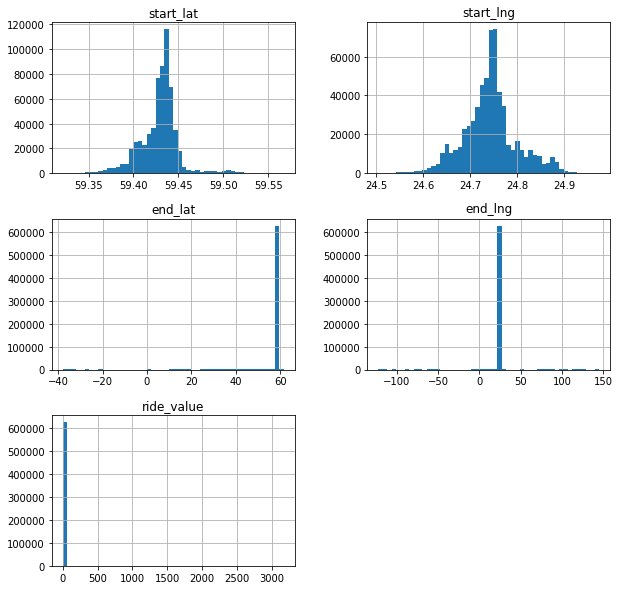

In [170]:
database.hist(figsize=(10,10),bins=50)

We can see that the data is quite centralized and the ride values are quite small. 

Let's also check for correlations. 

#### Clean, select, transform

At this phase the data is not usable yet hence will check what it includes, and we will work to explore and pre-prep it to be able to use it for deploying in the model. 

We will start by exploring trip information. We will convert the map projections of all the data from WGS84 to Estonian Coordinate System of 1997 since it has higher accuracy. 

In [171]:
#For the region of Tallinn
USER_EPSG = 3301

In [172]:
#create geodataframe for pick ups
print('converting pick ups')
start = [ Point(xy) for xy in zip(database.start_lng,database.start_lat) ]
gdf_start = gpd.GeoDataFrame(geometry = start,crs='epsg:4326').to_crs(USER_EPSG)
database['X_pick'] = gdf_start.geometry.x
database['Y_pick'] = gdf_start.geometry.y

print('converting drop offs')
end = [ Point(xy) for xy in zip(database.end_lng,database.end_lat) ]
gdf_end = gpd.GeoDataFrame(geometry = end,crs='epsg:4326').to_crs(USER_EPSG)
database['X_drop'] = gdf_end.geometry.x
database['Y_drop'] = gdf_end.geometry.y


converting pick ups
converting drop offs


Let's now convert the time into a more machine learning readable values (unix timestamps) and generate a new dataframe for usage.

In [173]:
database['timestamp'] = pd.to_datetime(database.start_time).astype(int)/10**9
df = database[['timestamp','X_pick','Y_pick','X_drop','Y_drop','ride_value']]

In [174]:
df.describe()

,timestamp,X_pick,Y_pick,X_drop,Y_drop,ride_value
count,6.272100e+05,627210.000000,6.272100e+05,6.272100e+05,6.272100e+05,627210.000000
mean,1.647371e+09,542197.584707,6.588105e+06,5.393640e+05,6.586525e+06,2.261384
std,6.946702e+05,3213.321104,2.443914e+03,2.283149e+05,1.181326e+05,44.889892
min,1.646093e+09,528697.463224,6.576120e+06,-1.826490e+07,-7.036577e+06,0.107628
25%,1.646784e+09,540479.993231,6.586993e+06,5.401858e+05,6.586593e+06,0.545250
50%,1.647419e+09,542266.653598,6.588487e+06,5.422466e+05,6.588329e+06,1.059000
75%,1.647985e+09,543590.092218,6.589267e+06,5.439280e+05,6.589291e+06,1.712000
max,1.648512e+09,555203.729668,6.603546e+06,2.097293e+07,1.524474e+07,3172.701000


Let's check the clean dataframe and the correlations

It's clear that this is a synthetic data and the the pick up and drop coordinates were generated from a single array and randomly meshed on the map. 

In [175]:
database['distances'] = gdf_start.geometry.distance(gdf_end)

<AxesSubplot:xlabel='distances', ylabel='ride_value'>

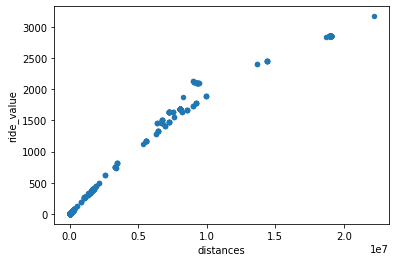

In [176]:
database.plot(x='distances',y='ride_value',kind='scatter')

From the GADM website (https://gadm.org/data.html), I downloaded the map of Estonia and filtered out city of Tallinn. Let's visualize the results.

In [177]:
#import maps
gdf_tallinn = gpd.read_file('tallinn.geojson')
gdf_tallinn['zone_NO'] = list(range(len(gdf_tallinn)))

In [178]:
gdf_tallinn.to_file('tallinn.geojson', driver="GeoJSON")  

<AxesSubplot:xlabel='X_pick', ylabel='Y_pick'>

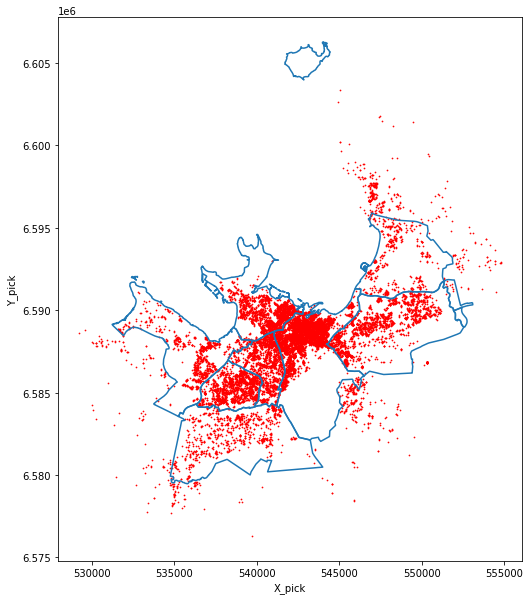

In [179]:
ax = gdf_tallinn.to_crs(USER_EPSG).exterior.plot()
df.sample(20000).plot(ax=ax,color='red',kind='scatter',x='X_pick',y='Y_pick',figsize=(10,10),s=0.5)

### Step 3: Deploying a model and assess

For the purpose of this assignment and in a simplified way, we will simply try to estimate the **ride_value** using Linear regression. We will use time and location as features and the **ride_value** as the label. 

After the preparing the data one last transformation can be beneficial which is normalization. I will standardize the data to use it for deployment 

#### Experiment 1: Sklearn linear

In [180]:
database.columns

Index(['start_time', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'ride_value', 'X_pick', 'Y_pick', 'X_drop', 'Y_drop', 'timestamp',
       'distances'],
      dtype='object')

In [181]:
log_dict={'experiment':[],'R2':[],'RMSE':[]}

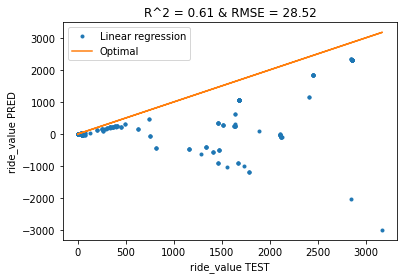

In [182]:
#Standardize
y = np.array(database.ride_value)
X = np.array(database[['timestamp','X_pick','Y_pick','X_drop','Y_drop']])
X = StandardScaler().fit_transform(X)

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

#apply model
model = LinearRegression().fit(X_train,y_train)

#re-predict the test database
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

plt.plot(y_test,y_pred,'.',label='Linear regression')
plt.plot(y_test,y_test,label='Optimal')
plt.legend()
plt.xlabel("ride_value TEST")
plt.ylabel("ride_value PRED")
plt.title(f'R^2 = {r2:.2f} & RMSE = {rmse:.2f}')
plt.show()

log_dict['experiment'].append("LR - raw")
log_dict['R2'].append(r2)
log_dict['RMSE'].append(rmse)


The result is quite interesting because we can see that all the predicted which are small are quite close to the optimal result and as the ride value increase the heteroscedasticity increase in a semi beneath a threshold scale. In most the cases the prediction is underestimated. When we took a look at the distance to ride value plot it was clear that there was a correlation and it would have been better to use a logarithmic function. Let's do another iteration and include the distance.

#### Experiment 2: Sklearn linear with new features

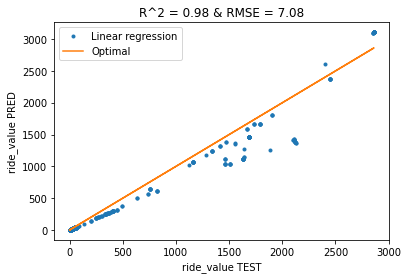

In [183]:
#Standardize
y = np.array(database.ride_value)
X = np.array(database[['timestamp','X_pick','Y_pick','X_drop','Y_drop','distances']])
X = StandardScaler().fit_transform(X)

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

#apply model
model = LinearRegression().fit(X_train,y_train)

#re-predict the test database
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

plt.plot(y_test,y_pred,'.',label='Linear regression')
plt.plot(y_test,y_test,label='Optimal')
plt.legend()
plt.xlabel("ride_value TEST")
plt.ylabel("ride_value PRED")
plt.title(f'R^2 = {r2:.2f} & RMSE = {rmse:.2f}')
plt.show()

log_dict['experiment'].append("LR - raw + distances")
log_dict['R2'].append(r2)
log_dict['RMSE'].append(rmse)


We have an improvement :)... we can see that the results are improving as there is a correlation with the distances. A final way is to check it using a power function between the distances and the ride value

#### Experiment 3: Sklearn with Power function as a new feature

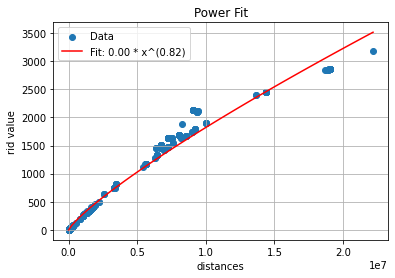

In [184]:

# Define the power function
def power_function(x, a, b):
    return a * np.power(x, b)

x_data = database['distances']
y_data = database['ride_value']


# Fit the curve
params, covariance = curve_fit(power_function, x_data, y_data)

# Extract the parameters
a_fit, b_fit = params

# Generate points for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = power_function(x_fit, a_fit, b_fit)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_fit, y_fit, 'r-', label='Fit: {:.2f} * x^({:.2f})'.format(a_fit, b_fit))
plt.xlabel('distances')
plt.ylabel('rid value')
plt.legend()
plt.title('Power Fit')
plt.grid(True)
plt.show()

In [185]:
database['power_distances'] =  power_function(database['distances'], a_fit, b_fit)

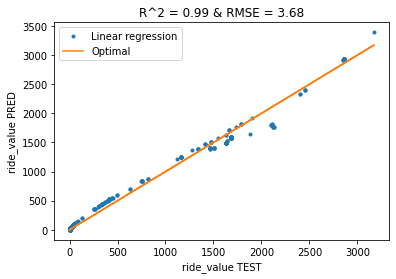

In [186]:
#Standardize
y = np.array(database.ride_value)
X = np.array(database[['timestamp','X_pick','Y_pick','X_drop','Y_drop','distances','power_distances']])
X = StandardScaler().fit_transform(X)

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

#apply model
model = LinearRegression().fit(X_train,y_train)

#re-predict the test database
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

plt.plot(y_test,y_pred,'.',label='Linear regression')
plt.plot(y_test,y_test,label='Optimal')
plt.legend()
plt.xlabel("ride_value TEST")
plt.ylabel("ride_value PRED")
plt.title(f'R^2 = {r2:.2f} & RMSE = {rmse:.2f}')
plt.show()


log_dict['experiment'].append("LR - raw + power(distances)")
log_dict['R2'].append(r2)
log_dict['RMSE'].append(rmse)

#### Experiment 4: Sklearn (ridge) with Power function as a new feature

Let's try another regression type: Random Forrest Regression

In [187]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

#apply model
model = Ridge().fit(X_train,y_train)

#re-predict the test database
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

log_dict['experiment'].append("Ridge- raw + power(distances)")
log_dict['R2'].append(r2)
log_dict['RMSE'].append(rmse)

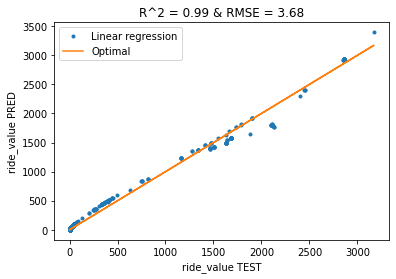

In [188]:
plt.plot(y_test,y_pred,'.',label='Linear regression')
plt.plot(y_test,y_test,label='Optimal')
plt.legend()
plt.xlabel("ride_value TEST")
plt.ylabel("ride_value PRED")
plt.title(f'R^2 = {r2:.2f} & RMSE = {rmse:.2f}')
plt.show()


In [189]:
pd.DataFrame(log_dict)

,experiment,R2,RMSE
0,LR - raw,0.613686,28.516182
1,LR - raw + distances,0.975294,7.079027
2,LR - raw + power(distances),0.992985,3.682741
3,Ridge- raw + power(distances),0.992919,3.675029


## Step 5: Act

### Post analysis and iteration

Usually for a data science project, after we make conclusions it is time to reiterate and check why our results were not that accurate, so we can:


1- Try different technical improvements:
* Implement other algorithms
* Implement hyper-parameter tuning to see if things can improve
* Try different regression algorithms and ensemble models and use the highest scoring model and so on

2 - Try domain knowledge improvements:  
One thing that needs to be considered in this project is the actual distances. As we know roads are not always straight forward, and the more longer you drive the more fuel you will spend and thus a trip will cost you more. So what would be an interesting addition to the database is adding real distances based on GPS data or the routes that the riders have taken. This can help with results and to make a more realistic prediction than just using straight lines which usually are misleading when the actual trip is not a straight line. 



As a data scientists you might end up doing some A/B testing. Let's say if you analysis is for a ride hailing or taxi company, profit and loss should be part of your equation. Then you might need additional information to do analysis: 
1. Pricing
2. Promotions
3. Customer churn
4. Etc ...

So some new additional data might be needed:
* Weather changes
* Special events 
* Time of day and weekday
* Rush hours information  and street traffic volumes  
* Point of intersect (POIs) which can cause traffic
* POI ratings to understand the quality of the region 
* Gentrification levels  
* Purchasing power of the community. 
* If the region is a student/university campus you might expect most of student to use public transport and carpool and they won't use the "comfort" version of the service. At least I was like that during my university years. I always waited for discounts and sometimes stopped using taxi hailing since it was out of my budget :) ....  


### A/B testing case study 

Let's think of Uber eats. Let's say we want to see if promotions are increasing the number of orders made for each user for food delivery and encouraging people to order more than usual. 

Hypothesis: 
* *Case A*: Personalization based promotions based on history of rides and ride values for location frequented a lot like work or university. 
* *Case B*: Random promotions

Target audience: 
* People who at least have one order per month ... (Frequent users) 

Algorithmically:
* Will this mock AI/recommender have an effect on the customers? 

Check results: 
* Yes: The total number of orders increased especially for the favorite places; we see that is the number of orders per month increased so people are more encouraged to order. 
* No: The number of orders stayed the same. 


**What we will learn**: 
Based on the results and the customer information, we will learn new things and aim to change the method of implementation of promotions based on the behavior of customers. And using recommender systems will increase number of orders and as a result the revenues.   




## Step 6: Deploy and monitor

As a data scientist when you finish experimentation a few steps are required. Of course in case you are more into MLOps, then you'll have to scale up your solution and deploy the product to serve it to the clients. Some issues that can occur is that the algorithm can drift, and start to deteriorate. That is when who have to reconsider the previous assumption and try to retrain. And remember that you won't be doing all of this on your own :) 
 
Here is a checklist of things you have to keep in mind: 

1. **Data Quality**:
   - Monitor input data quality.
   - Check for missing values, outliers, and data drift.


2. **Model Performance**:
   - Track model performance metrics.
   - Compare performance metrics on new data against the validation set or baseline.


3. **Prediction Latency**:
   - Monitor prediction latency.
   - Investigate and address any spikes or trends.


4. **Model Drift**:
   - Detect concept drift or data drift.
   - Retrain or update the model when significant drift is observed.


5. **Model Robustness**:
   - Test the model's robustness.
   - Monitor for unusual or unexpected behaviors.


6. **Resource Utilization**:
   - Monitor resource utilization.
   - Optimize resource allocation as needed.


7. **Feedback Loop**:
   - Establish a feedback loop.
   - Use feedback to retrain or fine-tune the model.


8. **Error Analysis**:
   - Analyze prediction errors.
   - Use error analysis to improve the model or data quality.


9. **Model Explainability**:
   - Ensure model's decisions are explainable.
   - Monitor interpretability of the model.


10. **Security and Privacy**:
    - Implement security measures.
    - Monitor for security threats.


11. **Model Versioning**:
    - Keep track of model versions.
    - Ensure proper versioning and rollback procedures.


12. **Compliance**:
    - Ensure compliance with regulatory requirements.
    - Monitor for compliance violations.




All of this as long as you have a mature data science team which is not stuck with bad quality data. As you know *Garbage in Garbage out*.

Cheers!
